# Fixed Income Duration Analysis
## ALM Management System — Portfolio Risk Assessment

---

**Duration** is the cornerstone metric for managing interest rate risk in fixed income portfolios. From a buy-side perspective, duration tells a portfolio manager how much their bond holdings will move in value when interest rates change — the single most important risk factor for any bond portfolio.

This notebook demonstrates our duration calculator module by analyzing a synthetic portfolio of five bonds across different maturities and credit qualities. We compute:

| Metric | What It Measures |
|---|---|
| **Macaulay Duration** | Weighted average time (years) to receive all cash flows |
| **Modified Duration** | Percentage price change per 1% yield move |
| **Convexity** | Second-order sensitivity — how duration itself changes with yields |
| **DV01** | Dollar value of a 1 basis point yield change (per \$100 face) |

These metrics form the foundation of interest rate risk management, immunization strategies, and regulatory reporting under Basel III IRRBB frameworks.

---
## 1. Environment Setup

In [8]:
import sys
from pathlib import Path

# Add project root to path so we can import our modules
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

from models.duration.duration_calculator import (
    DurationCalculator,
    CompoundingFrequency,
    DurationResult,
)

# Plot style
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "font.size": 11,
})

COLORS = ["#1f77b4", "#2ca02c", "#d62728", "#9467bd", "#ff7f0e"]

print("Environment ready.")

Environment ready.


---
## 2. Synthetic Bond Portfolio

We construct five bonds that represent common positions in an institutional fixed income portfolio. Yields and coupon rates reflect the 2024–2026 rate environment, with the Fed Funds rate elevated and a relatively flat-to-inverted curve.

All bonds use **semi-annual coupon payments** and a **\$1,000 face value**, consistent with U.S. Treasury and investment-grade corporate conventions.

In [9]:
# Bond portfolio definition
# Each bond: (name, maturity_years, annual_coupon_rate, ytm, category)
FACE_VALUE = 1_000

portfolio = [
    {"name": "2Y Treasury",   "maturity": 2,  "coupon": 0.0450, "ytm": 0.0430, "category": "Treasury"},
    {"name": "5Y Treasury",   "maturity": 5,  "coupon": 0.0400, "ytm": 0.0410, "category": "Treasury"},
    {"name": "10Y Treasury",  "maturity": 10, "coupon": 0.0425, "ytm": 0.0440, "category": "Treasury"},
    {"name": "30Y Treasury",  "maturity": 30, "coupon": 0.0475, "ytm": 0.0470, "category": "Treasury"},
    {"name": "5Y Corporate",  "maturity": 5,  "coupon": 0.0550, "ytm": 0.0560, "category": "Corporate"},
]


def build_cash_flows(maturity_years, annual_coupon_rate, face=FACE_VALUE):
    """Generate semi-annual cash flows and time vectors for a bullet bond."""
    periods = maturity_years * 2
    coupon_payment = face * annual_coupon_rate / 2  # semi-annual coupon

    times = [(i + 1) * 0.5 for i in range(periods)]
    cash_flows = [coupon_payment] * periods
    cash_flows[-1] += face  # principal returned at maturity

    return cash_flows, times


# Preview the 5Y Treasury cash flows
sample_cf, sample_t = build_cash_flows(5, 0.0400)
print("5Y Treasury (4.00% coupon) — Cash Flow Schedule:")
print(f"{'Period':>8} {'Time (yr)':>10} {'Cash Flow':>12}")
print("-" * 32)
for i, (t, cf) in enumerate(zip(sample_t, sample_cf), 1):
    print(f"{i:>8} {t:>10.1f} {cf:>12,.2f}")

5Y Treasury (4.00% coupon) — Cash Flow Schedule:
  Period  Time (yr)    Cash Flow
--------------------------------
       1        0.5        20.00
       2        1.0        20.00
       3        1.5        20.00
       4        2.0        20.00
       5        2.5        20.00
       6        3.0        20.00
       7        3.5        20.00
       8        4.0        20.00
       9        4.5        20.00
      10        5.0     1,020.00


---
## 3. Duration Calculations

We use `DurationCalculator` with **semi-annual compounding** to match U.S. bond market conventions. For each bond we compute:

- **Macaulay Duration** — the immunization duration (in years)
- **Modified Duration** — the first-order price sensitivity
- **Convexity** — the second-order price sensitivity
- **DV01** — dollar value of a 1 basis point yield change per \$100 face

In [10]:
calc = DurationCalculator(
    frequency=CompoundingFrequency.SEMI_ANNUAL,
    bump_size=0.0001,
)

results = []

for bond in portfolio:
    cash_flows, times = build_cash_flows(bond["maturity"], bond["coupon"])

    result = calc.calculate_all_durations(
        cash_flows=cash_flows,
        times=times,
        ytm=bond["ytm"],
    )

    # DV01 = dollar duration per basis point (dollar_duration is per 1%, so /100)
    dv01_per_100 = result.dollar_duration / 100  # per $100 face

    results.append({
        "Bond": bond["name"],
        "Category": bond["category"],
        "Maturity (yr)": bond["maturity"],
        "Coupon (%)": bond["coupon"] * 100,
        "YTM (%)": bond["ytm"] * 100,
        "Macaulay Dur": round(result.macaulay_duration, 4),
        "Modified Dur": round(result.modified_duration, 4),
        "Convexity": round(result.convexity, 4),
        "DV01 ($)": round(dv01_per_100, 4),
    })

df = pd.DataFrame(results)
df

,Bond,Category,Maturity (yr),Coupon (%),YTM (%),Macaulay Dur,Modified Dur,Convexity,DV01 ($)
0,2Y Treasury,Treasury,2,4.50,4.3,1.9351,1.8944,5.2872,0.1903
1,5Y Treasury,Treasury,5,4.00,4.1,4.5804,4.4884,24.6694,0.4477
2,10Y Treasury,Treasury,10,4.25,4.4,8.2409,8.0635,77.8748,0.7997
3,30Y Treasury,Treasury,30,4.75,4.7,16.3961,16.0197,362.7604,1.6288
4,5Y Corporate,Corporate,5,5.50,5.6,4.4385,4.3176,22.9912,0.4313


---
## 4. Visualizations

### 4a. Modified Duration by Bond

Modified duration is the go-to risk metric on any fixed income trading desk. It answers: *"If yields move 100 bp, how much does my bond price change (in percent)?"*

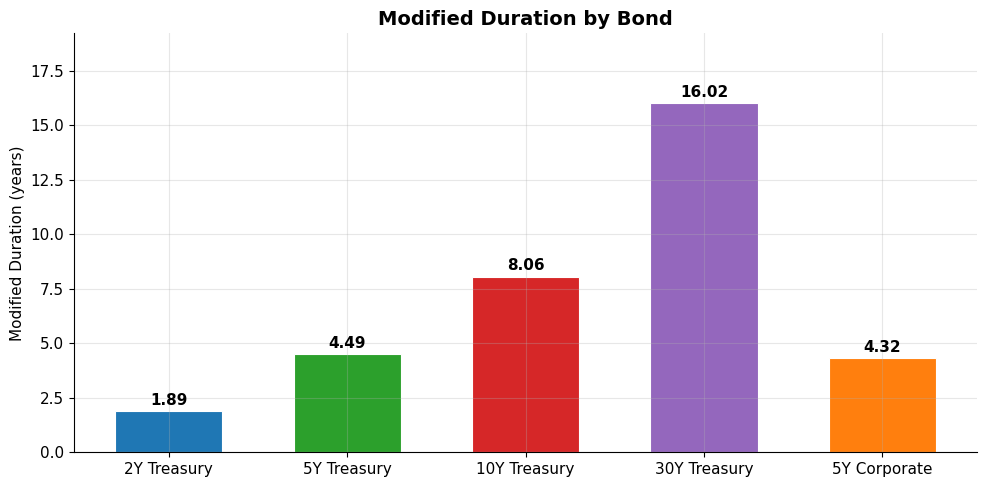

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

bars = ax.bar(
    df["Bond"],
    df["Modified Dur"],
    color=COLORS,
    edgecolor="white",
    linewidth=0.8,
    width=0.6,
)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.15,
        f"{height:.2f}",
        ha="center", va="bottom", fontweight="bold", fontsize=11,
    )

ax.set_ylabel("Modified Duration (years)")
ax.set_title("Modified Duration by Bond", fontsize=14, fontweight="bold")
ax.set_ylim(0, df["Modified Dur"].max() * 1.2)

plt.tight_layout()
plt.show()

### 4b. Duration vs. Maturity — The Non-Linear Relationship

A common misconception is that duration grows linearly with maturity. In reality, the relationship is **concave**: each additional year of maturity adds progressively less duration because distant cash flows are discounted more heavily. This is why a 30-year bond does not have 15x the duration of a 2-year bond.

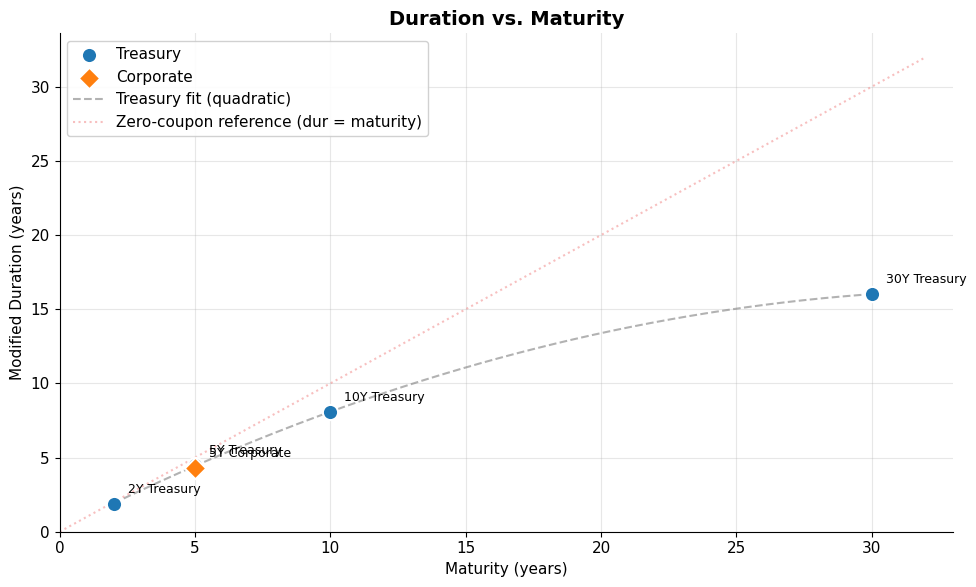

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Treasuries and Corporate separately
for category, marker, size in [("Treasury", "o", 120), ("Corporate", "D", 120)]:
    mask = df["Category"] == category
    subset = df[mask]
    ax.scatter(
        subset["Maturity (yr)"],
        subset["Modified Dur"],
        s=size,
        marker=marker,
        label=category,
        zorder=5,
        edgecolors="white",
        linewidth=1.5,
    )

# Fit and plot a smooth curve through Treasuries only
tsy = df[df["Category"] == "Treasury"].sort_values("Maturity (yr)")
mat_fine = np.linspace(tsy["Maturity (yr)"].min(), tsy["Maturity (yr)"].max(), 200)
coeffs = np.polyfit(tsy["Maturity (yr)"], tsy["Modified Dur"], 2)
dur_fit = np.polyval(coeffs, mat_fine)
ax.plot(mat_fine, dur_fit, "--", color="gray", alpha=0.6, label="Treasury fit (quadratic)")

# Annotate each point
for _, row in df.iterrows():
    ax.annotate(
        row["Bond"],
        (row["Maturity (yr)"], row["Modified Dur"]),
        textcoords="offset points",
        xytext=(10, 8),
        fontsize=9,
    )

# Reference line: if duration == maturity (zero-coupon)
ax.plot(
    [0, 32], [0, 32],
    ":", color="lightcoral", alpha=0.5,
    label="Zero-coupon reference (dur = maturity)",
)

ax.set_xlabel("Maturity (years)")
ax.set_ylabel("Modified Duration (years)")
ax.set_title("Duration vs. Maturity", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", framealpha=0.9)
ax.set_xlim(0, 33)
ax.set_ylim(0, None)

plt.tight_layout()
plt.show()

### 4c. Convexity by Maturity

Convexity is the "bonus" that long-duration holders receive: it makes the price–yield curve bow upward, meaning prices **rise more** than duration predicts when yields fall, and **fall less** when yields rise. This asymmetry becomes significant for large rate moves and is especially pronounced in long-dated bonds.

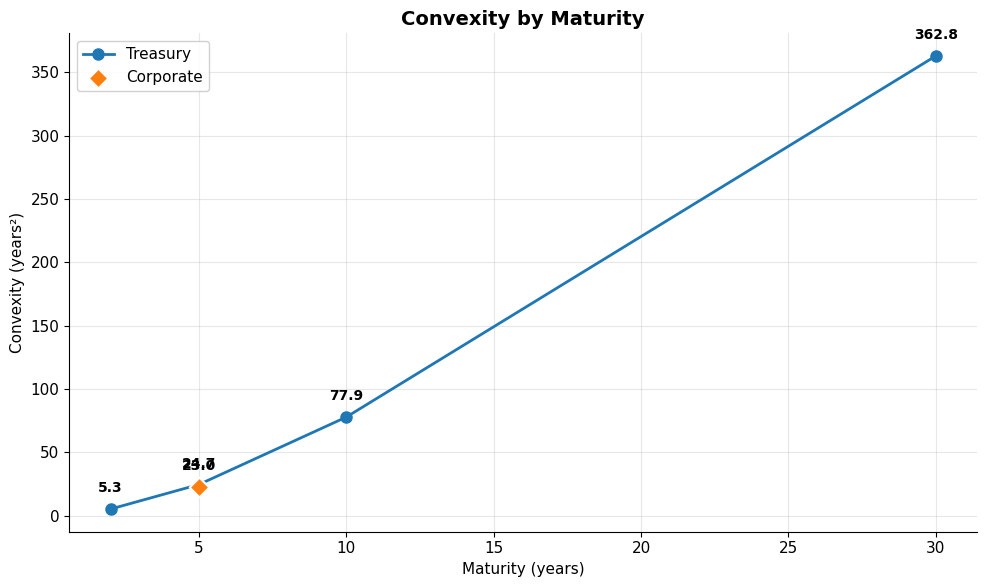

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))

tsy_sorted = df[df["Category"] == "Treasury"].sort_values("Maturity (yr)")
corp_sorted = df[df["Category"] == "Corporate"].sort_values("Maturity (yr)")

ax.plot(
    tsy_sorted["Maturity (yr)"],
    tsy_sorted["Convexity"],
    "o-",
    color=COLORS[0],
    markersize=8,
    linewidth=2,
    label="Treasury",
)
ax.scatter(
    corp_sorted["Maturity (yr)"],
    corp_sorted["Convexity"],
    s=100,
    marker="D",
    color=COLORS[4],
    zorder=5,
    edgecolors="white",
    linewidth=1.5,
    label="Corporate",
)

# Annotate convexity values
for _, row in df.iterrows():
    ax.annotate(
        f"{row['Convexity']:.1f}",
        (row["Maturity (yr)"], row["Convexity"]),
        textcoords="offset points",
        xytext=(0, 12),
        ha="center",
        fontsize=10,
        fontweight="bold",
    )

ax.set_xlabel("Maturity (years)")
ax.set_ylabel("Convexity (years²)")
ax.set_title("Convexity by Maturity", fontsize=14, fontweight="bold")
ax.legend(loc="upper left", framealpha=0.9)

plt.tight_layout()
plt.show()

### 4d. Complete Metrics Summary

A formatted table showing all computed metrics side-by-side.

In [14]:
# Build a styled summary table
summary = df[[
    "Bond", "Maturity (yr)", "Coupon (%)", "YTM (%)",
    "Macaulay Dur", "Modified Dur", "Convexity", "DV01 ($)",
]].copy()

summary = summary.set_index("Bond")

styled = (
    summary.style
    .format({
        "Maturity (yr)": "{:.0f}",
        "Coupon (%)": "{:.2f}",
        "YTM (%)": "{:.2f}",
        "Macaulay Dur": "{:.4f}",
        "Modified Dur": "{:.4f}",
        "Convexity": "{:.4f}",
        "DV01 ($)": "{:.4f}",
    })
    .background_gradient(
        subset=["Modified Dur"],
        cmap="YlOrRd",
    )
    .background_gradient(
        subset=["Convexity"],
        cmap="YlOrRd",
    )
    .set_caption("Bond Portfolio — Duration & Risk Metrics")
    .set_table_styles([
        {"selector": "caption", "props": "font-size: 14px; font-weight: bold; margin-bottom: 8px;"},
    ])
)

styled

,Maturity (yr),Coupon (%),YTM (%),Macaulay Dur,Modified Dur,Convexity,DV01 ($)
Bond,,,,,,,
2Y Treasury,2,4.50,4.30,1.9351,1.8944,5.2872,0.1903
5Y Treasury,5,4.00,4.10,4.5804,4.4884,24.6694,0.4477
10Y Treasury,10,4.25,4.40,8.2409,8.0635,77.8748,0.7997
30Y Treasury,30,4.75,4.70,16.3961,16.0197,362.7604,1.6288
5Y Corporate,5,5.50,5.60,4.4385,4.3176,22.9912,0.4313


---
## 5. Key Insights

### What Duration Tells a Portfolio Manager

Duration is effectively the **interest rate beta** of a bond. A portfolio with a modified duration of 8 will lose approximately 8% of its market value for every 100 basis point rise in rates. For an institution managing billions in fixed income assets, this translates directly into P&L impact:

> A \$1 billion portfolio with modified duration of 8 stands to lose **\$80 million** for a 100 bp rate increase.

### Observations from This Portfolio

1. **Duration increases with maturity, but not linearly.** The 30Y Treasury has roughly 15x the maturity of the 2Y but only about 9x the modified duration. This concavity is driven by discounting — distant cash flows contribute less to price sensitivity because they are worth less today.

2. **Convexity accelerates with maturity.** The 30Y bond's convexity dwarfs the short-end bonds. This is the "convexity advantage" — long bonds benefit disproportionately from rate rallies, which is why asset managers often prefer the long end when they expect rates to fall.

3. **Corporate vs. Treasury at the same maturity.** The 5Y Corporate has a *lower* modified duration than the 5Y Treasury despite having a higher yield. This is because the higher coupon (5.50% vs. 4.00%) returns more cash earlier, pulling the "center of gravity" of cash flows forward. For ALM purposes, this means corporate bonds provide *less* interest rate exposure per dollar invested.

4. **DV01 scales with duration and price.** DV01 is the metric most directly tied to hedging — it tells you the dollar amount at risk per basis point. Matching DV01 across assets and liabilities is the first step in any immunization strategy.

### Implications for ALM

- **Duration matching**: Set portfolio duration equal to the duration of liabilities to immunize against parallel yield curve shifts.
- **Convexity management**: Positive convexity in assets vs. liabilities creates a natural hedge against large rate moves.
- **Key rate analysis**: Parallel shifts are an approximation. Real yield curve moves are non-parallel, which is why key rate durations (covered in a future notebook) are essential for precision hedging.

---

*ALM Management System — Duration Analysis Module*